# Movement Recognition

This notebook contains the main code for the movement recognition tasks. It loads the participant data, preprocesses it and uses this data to train the different models either on the execution task, or on the observation task.

### Import librairies

In [ ]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
torch.use_deterministic_algorithms(True) # PyTorch will use deterministic algorithms fro operations with stochastic behavior like dropout
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num
torch.manual_seed(seed_num) # PyTorch's random number will use seed_num

### Data loading

Change here the participant to load.

In [2]:
part_name = 's6'
use_saved = True

In [3]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

### Possible hyperparameters for MLP models.

In [5]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }, # more complex, might require higher learning rate
    '32_16_02': {
        'layers': (32, 16),
        'lr': 0.2
    }
}

## Execution

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [6]:
if use_saved and os.path.exists(f'saved/ex_features_{part_name}_mvt.h5'):
    ex_features = pd.read_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df')
else:
    ex_features = participant.get_features_all_sessions_mvt('E')
    ex_features.to_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [7]:
print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_ex)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 128 samples and 4897 features.
The 68 relevant channels are located in the following locations:
{'WM_paracentral': 1, 'supramarginal': 3, 'insula': 3, 'WM_insula': 1, 'precentral': 26, 'paracentral': 3, 'postcentral': 16, 'WM_precentral': 6, 'superiorfrontal': 5, 'caudalmiddlefrontal': 4}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [8]:
if use_saved and os.path.exists(f'saved/ex_baseline_features_{part_name}_mvt.h5'):
    ex_baseline_features = pd.read_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df')
else:
    ex_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='E')
    ex_baseline_features.to_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [9]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [10]:
accuracies_ex = {}
accuracies_ex_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [11]:
X = ex_baseline_features.drop('label', axis=1)
y = ex_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR'] = accuracy

Accuracy: 0.64


#### With PCA

In [12]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR PCA'] = accuracy

Accuracy: 0.59


### Train a model (SVM)

In [13]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [14]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [15]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpMRexbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6879
Model 8_16_01 Validation Loss: 0.6908
Model 16_16_01 Validation Loss: 0.6881
Model 32_16_01 Validation Loss: 0.6855


For s6, the best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [ ]:
mlp = MLP(X_train.shape[1], 2, layers=models['32_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRexbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex_baseline['MLP'] = acc

Accuracy: 0.45


## Let's now do the analysis for the responsive channels

In [70]:
X = ex_features.drop('label', axis=1)
y = ex_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [71]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR'] = accuracy

Accuracy: 0.77


#### With PCA

In [72]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR PCA'] = accuracy

Accuracy: 0.69


### Train a model (SVM)

In [73]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [74]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [75]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [76]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpMRex_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6986
Model 8_16_01 Validation Loss: 0.6898
Model 16_16_01 Validation Loss: 0.6967
Model 32_16_01 Validation Loss: 0.6999


The best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [19]:
mlp = MLP(X_train.shape[1], 2, layers=models['16_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRex_16_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex['MLP'] = acc

FileNotFoundError: [Errno 2] No such file or directory: 'saved/mlpMRex_16_16_01.pth'

## Observation

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [79]:
if use_saved and os.path.exists(f'saved/obs_features_{part_name}_mvt.h5'):
    obs_features = pd.read_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df')
else:
    obs_features = participant.get_features_all_sessions_mvt('O')
    obs_features.to_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [80]:
print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

The dataset contains 128 samples and 3673 features.


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

In [81]:
if use_saved and os.path.exists(f'saved/obs_baseline_features_{part_name}_mvt.h5'):
    obs_baseline_features = pd.read_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df')
else:
    obs_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='O')
    obs_baseline_features.to_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [82]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [83]:
accuracies_obs = {}
accuracies_obs_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [84]:
X = obs_baseline_features.drop('label', axis=1)
y = obs_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR'] = accuracy

Accuracy: 0.49


#### With PCA

In [85]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR PCA'] = accuracy

Accuracy: 0.49


### Train a model (SVM)

In [86]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM'] = accuracy

Accuracy: 0.44


#### With PCA

In [87]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM PCA'] = accuracy

Accuracy: 0.54


### Train a model (Random Forest)

In [88]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['RF'] = accuracy

Accuracy: 0.54


### Train a model (Multi-Layer Perceptron)

In [89]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpMRobsbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6947
Model 8_16_01 Validation Loss: 0.7064
Model 16_16_01 Validation Loss: 0.6996
Model 32_16_01 Validation Loss: 0.6947


In [91]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobsbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs_baseline['MLP'] = acc

Accuracy: 0.60


## Let's now do the analysis for the responsive channels

In [92]:
X = obs_features.drop('label', axis=1)
y = obs_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [93]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR'] = accuracy

Accuracy: 0.62


#### With PCA

In [94]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR PCA'] = accuracy

Accuracy: 0.51


### Train a model (SVM)

In [95]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM'] = accuracy

Accuracy: 0.51


#### With PCA

In [96]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [97]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [98]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpMRobs_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


Epoch: 1 	Training Loss: 0.796478 	Training Acc: 0.426966


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 1 	Validation Loss: 0.689109 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]


Epoch: 2 	Training Loss: 0.696628 	Training Acc: 0.438202


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch: 2 	Validation Loss: 0.682022 	Validation Acc: 0.684211


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.02it/s]


Epoch: 3 	Training Loss: 0.697166 	Training Acc: 0.483146


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 3 	Validation Loss: 0.690436 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  5.94it/s]


Epoch: 4 	Training Loss: 0.695975 	Training Acc: 0.505618


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 4 	Validation Loss: 0.685850 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.27it/s]


Epoch: 5 	Training Loss: 0.696045 	Training Acc: 0.516854


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 5 	Validation Loss: 0.699262 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]


Epoch: 6 	Training Loss: 0.695560 	Training Acc: 0.494382


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 6 	Validation Loss: 0.708731 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:06<00:00,  3.38it/s]


Epoch: 7 	Training Loss: 0.696826 	Training Acc: 0.404494


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 7 	Validation Loss: 0.704661 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.06it/s]


Epoch: 8 	Training Loss: 0.695294 	Training Acc: 0.483146


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 8 	Validation Loss: 0.696730 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.39it/s]


Epoch: 9 	Training Loss: 0.697029 	Training Acc: 0.449438


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch: 9 	Validation Loss: 0.712541 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.35it/s]


Epoch: 10 	Training Loss: 0.694702 	Training Acc: 0.528090


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Epoch: 10 	Validation Loss: 0.682417 	Validation Acc: 0.684211


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.37it/s]


Epoch: 1 	Training Loss: 1.185224 	Training Acc: 0.595506


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 1 	Validation Loss: 0.672074 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.47it/s]


Epoch: 2 	Training Loss: 0.695178 	Training Acc: 0.471910


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch: 2 	Validation Loss: 0.703387 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  4.71it/s]


Epoch: 3 	Training Loss: 0.697826 	Training Acc: 0.471910


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch: 3 	Validation Loss: 0.719050 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  4.98it/s]


Epoch: 4 	Training Loss: 0.694804 	Training Acc: 0.471910


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 4 	Validation Loss: 0.686475 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.49it/s]


Epoch: 5 	Training Loss: 0.696461 	Training Acc: 0.404494


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch: 5 	Validation Loss: 0.704230 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  6.66it/s]


Epoch: 6 	Training Loss: 0.697203 	Training Acc: 0.471910


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch: 6 	Validation Loss: 0.702907 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  5.93it/s]


Epoch: 7 	Training Loss: 0.694795 	Training Acc: 0.505618


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 7 	Validation Loss: 0.697479 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Epoch: 8 	Training Loss: 0.694594 	Training Acc: 0.494382


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch: 8 	Validation Loss: 0.702646 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.68it/s]


Epoch: 9 	Training Loss: 0.698015 	Training Acc: 0.471910


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 9 	Validation Loss: 0.712768 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:03<00:00,  5.75it/s]


Epoch: 10 	Training Loss: 0.694363 	Training Acc: 0.505618


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch: 10 	Validation Loss: 0.694454 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.48it/s]


Epoch: 1 	Training Loss: 1.471866 	Training Acc: 0.494382


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 1 	Validation Loss: 0.709231 	Validation Acc: 0.315789


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.11it/s]


Epoch: 2 	Training Loss: 0.693511 	Training Acc: 0.505618


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 2 	Validation Loss: 0.682194 	Validation Acc: 0.684211


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


Epoch: 3 	Training Loss: 0.696708 	Training Acc: 0.426966


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 3 	Validation Loss: 0.701703 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.47it/s]


Epoch: 4 	Training Loss: 0.697169 	Training Acc: 0.505618


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 4 	Validation Loss: 0.697555 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  3.85it/s]


Epoch: 5 	Training Loss: 0.692407 	Training Acc: 0.505618


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch: 5 	Validation Loss: 0.681277 	Validation Acc: 0.684211


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch: 6 	Training Loss: 0.694517 	Training Acc: 0.516854


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 6 	Validation Loss: 0.710537 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.19it/s]


Epoch: 7 	Training Loss: 0.694452 	Training Acc: 0.494382


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch: 7 	Validation Loss: 0.717566 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.12it/s]


Epoch: 8 	Training Loss: 0.696210 	Training Acc: 0.471910


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 8 	Validation Loss: 0.702382 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]


Epoch: 9 	Training Loss: 0.698471 	Training Acc: 0.404494


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 9 	Validation Loss: 0.711762 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  3.90it/s]


Epoch: 10 	Training Loss: 0.695333 	Training Acc: 0.449438


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 10 	Validation Loss: 0.705347 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Epoch: 1 	Training Loss: 16.784466 	Training Acc: 0.471910


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch: 1 	Validation Loss: 0.685744 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.08it/s]


Epoch: 2 	Training Loss: 0.694695 	Training Acc: 0.483146


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 2 	Validation Loss: 0.705505 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


Epoch: 3 	Training Loss: 0.695730 	Training Acc: 0.494382


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch: 3 	Validation Loss: 0.685870 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]


Epoch: 4 	Training Loss: 0.699862 	Training Acc: 0.449438


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 4 	Validation Loss: 0.685930 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]


Epoch: 5 	Training Loss: 0.698300 	Training Acc: 0.438202


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch: 5 	Validation Loss: 0.700604 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.32it/s]


Epoch: 6 	Training Loss: 0.695985 	Training Acc: 0.449438


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch: 6 	Validation Loss: 0.689137 	Validation Acc: 0.684211


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:04<00:00,  5.45it/s]


Epoch: 7 	Training Loss: 0.694788 	Training Acc: 0.528090


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch: 7 	Validation Loss: 0.689430 	Validation Acc: 0.684211


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:07<00:00,  3.18it/s]


Epoch: 8 	Training Loss: 0.696617 	Training Acc: 0.460674


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch: 8 	Validation Loss: 0.696031 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:07<00:00,  3.06it/s]


Epoch: 9 	Training Loss: 0.697455 	Training Acc: 0.404494


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Epoch: 9 	Validation Loss: 0.684100 	Validation Acc: 0.684211


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]


Epoch: 10 	Training Loss: 0.695693 	Training Acc: 0.471910


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

Epoch: 10 	Validation Loss: 0.683130 	Validation Acc: 0.684211
Model 8_8_01 Validation Loss: 0.6824
Model 8_16_01 Validation Loss: 0.6945
Model 16_16_01 Validation Loss: 0.7053
Model 32_16_01 Validation Loss: 0.6831


The best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [100]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobs_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs['MLP'] = acc

Accuracy: 0.40


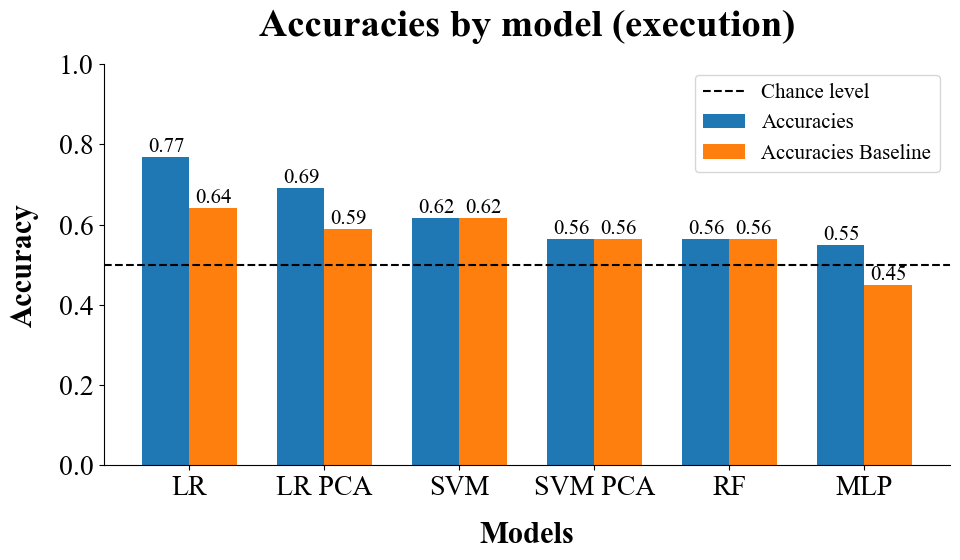

In [101]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_ex.keys()

dataset_values = [accuracies_ex[model] for model in models]
baseline_values = [accuracies_ex_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (execution)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)

plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ex.png')
plt.show()


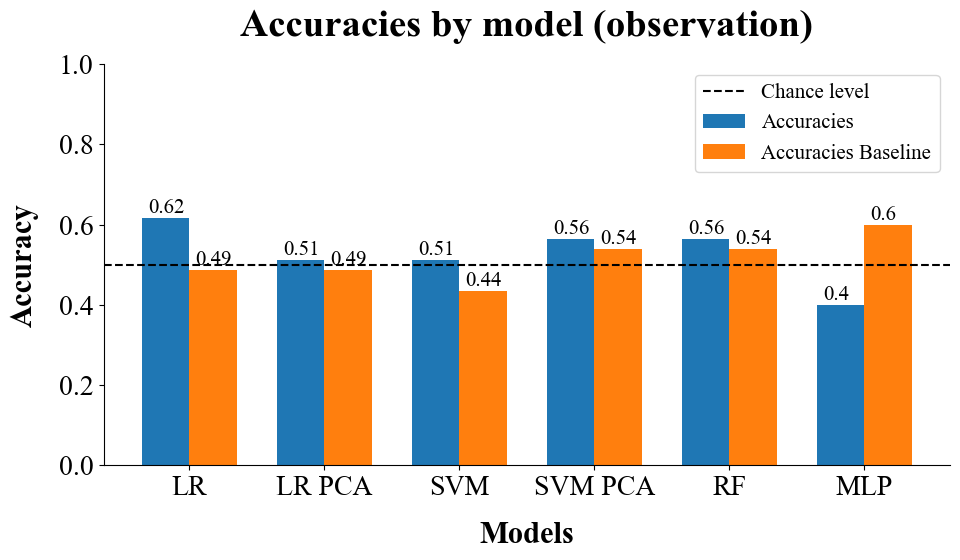

In [102]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_obs.keys()

dataset_values = [accuracies_obs[model] for model in models]
baseline_values = [accuracies_obs_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (observation)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)

plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)
  
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_obs.png')
plt.show()
